In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import random

In [118]:
random.seed(237817)

# Setting these as global variables so that they can be shuffled to ensure an even distribution- many times I wasn't getting all 24/720 labels in the validation set

images = np.load("75/images.npy")
labels = np.load("75/labels.npy")

size = 75
images = np.load(f'{size}/images.npy')
total = 18000
split = int(total*0.8)

indices = np.random.permutation(images.shape[0])
shuffled_images = images[indices,:,:]
shuffled_labels = labels[indices,:]

train_images = shuffled_images[0:split,:,:]
train_labels = shuffled_labels[0:split,:]

test_images = shuffled_images[split:,:,:]
test_labels = shuffled_labels[split:,:]

valid_images = train_images[0:500,:,:]
valid_labels = train_labels[0:500,:]

train_images = train_images[500:,:,:]
train_labels = train_labels[500:,:]

train_images = train_images / 255.0
test_images = test_images / 255.0
valid_images = valid_images / 255.0

train_images = train_images.reshape(train_images.shape[0],75,75,1)
test_images  = test_images.reshape(test_images.shape[0],75,75,1)
valid_images = valid_images.reshape(valid_images.shape[0],75,75,1)

train_labels = train_labels.astype("float32")
test_labels = test_labels.astype("float32")
valid_labels = valid_labels.astype("float32")

train_hours = train_labels[:,0]
train_minutes = train_labels[:,1]
test_hours = test_labels[:,0]
test_minutes = test_labels[:,1]
valid_hours = valid_labels[:,0] 
valid_minutes = valid_labels[:,1]

# Convert the time into 24 separate labels
def conv_time_24(hours, minutes):
    h, m = int, float
    if minutes <= .50:
        h = int(hours)
        m = 0.5
    else:
      m = 0
      h = int(hours)
    
    return h, m

# Convert the time into 720 separate labels 
def conv_time_720(time):
    return time[0]*60 + time[1]

conv_time = conv_time_24

y_train_converted = np.empty(13900, dtype=float)
y_test_converted = np.empty(3600, dtype=float)
y_valid_converted = np.empty(500, dtype=float)

for i in range(len(train_hours)):
    hours, minutes = conv_time(train_hours[i], train_minutes[i]/60)
    y_train_converted[i] = hours + float(minutes)
    
for i in range(len(test_hours)):
    hours, minutes = conv_time(test_hours[i], test_minutes[i]/60)
    y_test_converted[i] = hours + float(minutes) 
    
for i in range(len(valid_hours)):   
    hours, minutes = conv_time(valid_hours[i], valid_minutes[i]/60)
    y_valid_converted[i] = hours + float(minutes)

encoder = LabelEncoder()
y_test_encoded = encoder.fit_transform(y_test_converted)
y_train_encoded = encoder.fit_transform(y_train_converted)
y_valid_encoded = encoder.fit_transform(y_valid_converted)

## Classification Model

In [119]:

OH_Encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = OH_Encoder.fit_transform(y_train_encoded.reshape(-1, 1))
onehot_encoded_valid = OH_Encoder.fit_transform(y_valid_encoded.reshape(-1, 1))

In [120]:
import tensorflow.keras.backend as K

#Common sense error function- checks the smaller of the differences by converting to military time
def common_sense_error(true, pred):
    diff1 = K.abs(pred-true)
    diff2 = K.abs(pred+12-true)
    return K.minimum(diff1, diff2)

In [121]:
np.random.seed(9999)


# Classification CNN
input_shape=(images.shape[1], images.shape[2], 1)
print(train_images.shape, onehot_encoded.shape, input_shape)

model_classification = tf.keras.models.Sequential()
model_classification.add(Input(shape=input_shape))
model_classification.add(Conv2D(kernel_size=(5,5), strides = (2,2), activation="relu", filters=32))
model_classification.add(Conv2D(activation="relu", filters=32, kernel_size=(3,3), input_shape=input_shape))
model_classification.add(MaxPooling2D(pool_size=2))
model_classification.add(Conv2D(kernel_size=(3,3), activation="relu", filters=32))
model_classification.add(Conv2D(kernel_size=(3,3), activation="relu", filters=32))
model_classification.add(MaxPooling2D(pool_size=2))
model_classification.add(Conv2D(kernel_size=(3,3), activation="relu", filters=64))
model_classification.add(Conv2D(kernel_size=(3,3), activation="relu", filters=64))


model_classification.add(Flatten())
model_classification.add(Dense(units=1024, activation="relu"))
model_classification.add(Dense(units=512, activation="relu"))
model_classification.add(Dense(units=512, activation="relu"))
model_classification.add(Dense(units=256, activation="relu"))
model_classification.add(Dense(units=256, activation="relu"))
model_classification.add(Dense(units=128, activation="relu"))
model_classification.add(Dense(units=64, activation="relu"))
model_classification.add(Dense(units=32, activation="relu"))
model_classification.add(Dense(units=24, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_classification.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 15)

(13900, 75, 75, 1) (13900, 24) (75, 75, 1)


/vol/home/s4201388/Documents/Leiden/IDL/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [122]:
cl_h = model_classification.fit(train_images, onehot_encoded, epochs=50, batch_size=180, validation_data=(valid_images, onehot_encoded_valid), callbacks=[early_stop])

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.0455 - loss: 3.1780 - val_accuracy: 0.0380 - val_loss: 3.1780
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.0421 - loss: 3.1778 - val_accuracy: 0.0380 - val_loss: 3.1779
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.0427 - loss: 3.1778 - val_accuracy: 0.0380 - val_loss: 3.1777
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.0418 - loss: 3.1781 - val_accuracy: 0.0380 - val_loss: 3.1776
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.0414 - loss: 3.1778 - val_accuracy: 0.0500 - val_loss: 3.1776
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.0393 - loss: 3.1779 - val_accuracy: 0.0500 - val_loss: 3.1771
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.0414 - loss: 3.1774 - val_accuracy: 0.0380 - val_loss: 3.1776
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.0386 - loss: 3.1781 - val_accuracy: 0.0500 - v

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


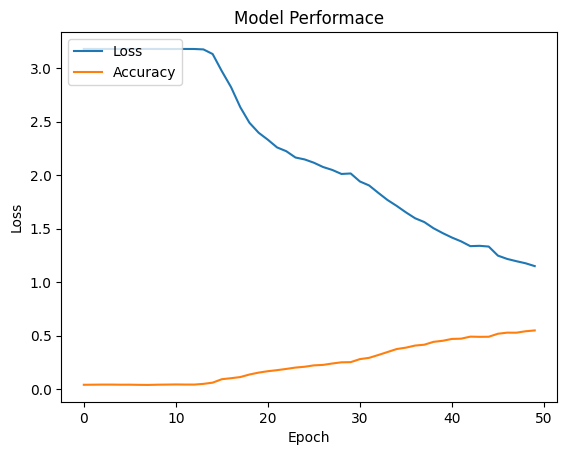

In [123]:
# Graph the model training
print(cl_h.history.keys())
plt.plot(cl_h.history['loss'])
plt.plot(cl_h.history['accuracy'])
plt.title('Model Performace')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'], loc='upper left')

In [124]:
# Measuring accuracy- picking the highest confidence label and comparing it to the true label
predicted = model_classification.predict(test_images)
predicted = np.argmax(predicted, axis=1)

print(np.sum(predicted == y_test_encoded) / len(y_test_encoded) * 100, "%")

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
50.30555555555556 %


## Regression Model

In [125]:
import tensorflow.keras.backend as K

#returning the common sense difference between two times
def common_sense_error(true, pred):
    true = K.cast(true, 'float32')
    diff_1 = K.abs(true - pred)
    diff_2 = K.abs(true - (pred + 12))

    return K.minimum(diff_1, diff_2)

In [129]:
# Convert the time into a continuous value
def conv_time(time):
    return time[0] + time[1]/60

train_labels_reg = np.array([conv_time(time) for time in train_labels])
test_labels_reg = np.array([conv_time(time) for time in test_labels])
val_labels_reg = np.array([conv_time(time) for time in valid_labels])

model_regression = tf.keras.models.Sequential()

model_regression.add(Conv2D(kernel_size=(5,5), strides = (2,2), activation="relu", filters=32))
model_regression.add(Conv2D(activation='relu', filters=32, kernel_size=(3,3), input_shape=(75, 75, 1)))
model_regression.add(MaxPooling2D(pool_size=2))
model_regression.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_regression.add(Conv2D(filters=32 ,kernel_size=(3,3), activation='relu'))
model_regression.add(MaxPooling2D(pool_size=2))
model_regression.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_regression.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_regression.add(MaxPooling2D(pool_size=2))


model_regression.add(Flatten())
model_regression.add(Dense(units=1024, activation='relu'))
model_regression.add(Dense(units=512, activation='relu'))
model_regression.add(Dense(units=512, activation='relu'))
model_regression.add(Dense(units=256, activation='relu'))
model_regression.add(Dense(units=256, activation='relu'))
model_regression.add(Dense(units=128, activation='relu'))
model_regression.add(Dense(units=64, activation='relu'))
model_regression.add(Dense(units=32, activation='relu'))
model_regression.add(Dense(units=16, activation='relu'))
model_regression.add(Dense(units=1, activation="softplus"))
model_regression.compile(loss="mse", optimizer="adam", metrics=[common_sense_error, "mae"])

early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

r_h = model_regression.fit(train_images, train_labels_reg, epochs=50, batch_size = 512, validation_data = (valid_images, val_labels_reg), callbacks = [early_stop])

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - common_sense_error: 3.0741 - loss: 32.7871 - mae: 4.7214 - val_common_sense_error: 3.2125 - val_loss: 16.8995 - val_mae: 3.5146
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - common_sense_error: 2.9986 - loss: 13.1379 - mae: 3.0825 - val_common_sense_error: 3.0878 - val_loss: 12.7076 - val_mae: 3.0913
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - common_sense_error: 2.9949 - loss: 11.9586 - mae: 2.9937 - val_common_sense_error: 3.1203 - val_loss: 12.9337 - val_mae: 3.1265
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - common_sense_error: 3.0011 - loss: 12.0437 - mae: 3.0003 - val_common_sense_error: 3.0859 - val_loss: 12.7018 - val_mae: 3.0889
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - common_sense_error: 3.0034 - loss: 12.0198 - mae: 3.0015 - val_common_sense_error: 3.0961 - val_loss: 12.7343 - val_mae: 3.0992
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - common_sense_error: 3.0000 - loss: 12.0057

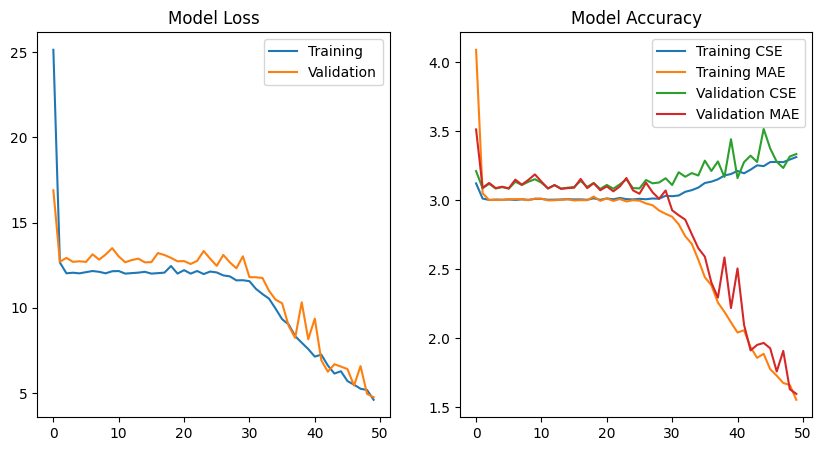

In [130]:
# Graph the model training
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(r_h.history["loss"])
ax[0].plot(r_h.history["val_loss"])
ax[0].legend(["Training", "Validation"])
ax[0].set_title("Model Loss")

ax[1].set_title("Model Accuracy")
ax[1].plot(r_h.history["common_sense_error"])
ax[1].plot(r_h.history["mae"])
ax[1].plot(r_h.history["val_common_sense_error"])
ax[1].plot(r_h.history["val_mae"])
ax[1].legend(["Training CSE", "Training MAE", "Validation CSE", "Validation MAE"])
plt.show()

In [ ]:
# Measuring accuracy within 1 minute of the true time
reg_preds = model_regression.predict(test_images)
total_error_time = 0
for i in range(len(test_images)):
    error = float(common_sense_error(test_labels_reg[i], reg_preds[i]))
    total_error_time += round(error, 4)
average_error_time = round(total_error_time/len(test_images), 4)
print("Average common sense error is", average_error_time//1, "hours", (average_error_time%1)*60, "minutes")

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Average common sense error is 1.0 hours 29.333999999999993 minutes


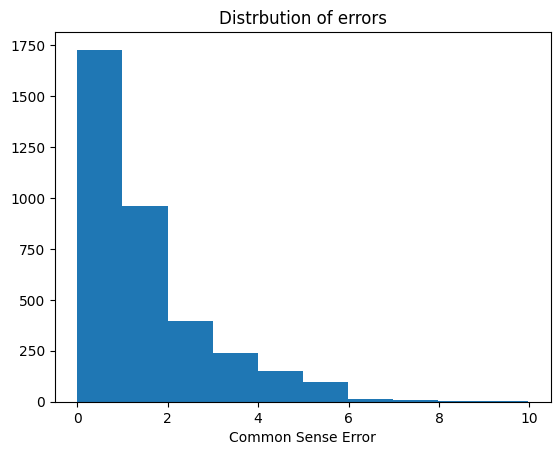

In [138]:
errors = [round(float(common_sense_error(test_labels_reg[i], reg_preds[i])), 4) for i in range(len(test_images))]
plt.hist(errors)
plt.title("Distrbution of errors")
plt.xlabel("Common Sense Error")
plt.show()

## Two-Headed Model

In [139]:
import tensorflow.keras.backend as K

def common_sense_hour(true, pred):
    diff1 = abs(pred-true)
    diff2 = abs(pred+12-true)
    return min(diff1, diff2)

def common_sense_minute(true, pred):
    true = K.cast(true, 'float32')
    diff1 = K.abs(pred-true)
    diff2 = K.abs(pred+60-true)
    return K.minimum(diff1, diff2)

In [140]:
OH_Encoder = OneHotEncoder(sparse_output=False)
two_head_train_hours = OH_Encoder.fit_transform(train_hours.reshape(-1, 1))
two_head_val_hours = OH_Encoder.fit_transform(valid_hours.reshape(-1, 1))

In [143]:
inp = Input(shape = (75,75,1))

two_head_model = Conv2D(32,kernel_size = (5,5), strides= (2,2), activation = "relu")(inp)
two_head_model = MaxPooling2D(pool_size =2)(two_head_model)
two_head_model = Conv2D(32,kernel_size = (3,3),activation = "relu")(two_head_model)
two_head_model = Conv2D(32,kernel_size = (3,3),activation = "relu")(two_head_model)
two_head_model = MaxPooling2D(pool_size =2)(two_head_model)
two_head_model = Conv2D(64,kernel_size = (3,3),activation = "relu")(two_head_model)
two_head_model = Conv2D(64,kernel_size = (1,1),activation = "relu")(two_head_model)
two_head_model = Flatten()(two_head_model)

d = Dense(512,activation = "relu")(two_head_model)
d = Dense(512,activation = "relu")(d)
d = tf.keras.layers.Dropout(0.1)(d)
d = Dense(256,activation = "relu")(d)

# The hour head predicts confidence amonst 12 label classes- one for each hour 
hour = Dense(256,activation = "relu")(d)
hour = Dense(128,activation = "relu")(hour)
hour = Dense(64,activation = "relu")(hour)
hour = Dense(32,activation = "relu")(hour)
hour = Dense(16,activation = "relu")(hour)
hour = Dense(12,activation= "softmax", name= "hour")(hour)

# The minute head runs a regression on a continuous value
minute = Dense(256,activation = "relu")(d)
minute = Dense(256,activation = "relu")(minute)
minute = Dense(256,activation = "relu")(minute)
minute = Dense(128,activation = "relu")(minute)
minute = Dense(64,activation = "relu")(minute)
minute = Dense(32,activation = "relu")(minute)
minute = Dense(16,activation = "relu")(minute)
minute = Dense(1, activation = "softplus", name = "minute")(minute)

model = tf.keras.models.Model(inputs=inp, outputs=[hour, minute])
optim = tf.keras.optimizers.Adam()
model.compile(loss=['categorical_crossentropy', 'mse'], optimizer=optim, metrics=['accuracy',"mae"])

print(train_hours.shape, train_minutes.shape, train_images.shape, valid_hours.shape)

early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)
model.fit(train_images, [two_head_train_hours, train_minutes/60], epochs=30, batch_size = 512, validation_data = (valid_images, [two_head_val_hours, valid_minutes/60]), callbacks = [early_stop])

(13900,) (13900,) (13900, 75, 75, 1) (500,)
Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - hour_accuracy: 0.0792 - hour_loss: 2.4869 - loss: 2.5827 - minute_loss: 0.0958 - minute_mae: 0.2623 - val_hour_accuracy: 0.0880 - val_hour_loss: 2.4852 - val_loss: 2.5673 - val_minute_loss: 0.0821 - val_minute_mae: 0.2510
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - hour_accuracy: 0.0782 - hour_loss: 2.4853 - loss: 2.5690 - minute_loss: 0.0838 - minute_mae: 0.2500 - val_hour_accuracy: 0.0700 - val_hour_loss: 2.4862 - val_loss: 2.5683 - val_minute_loss: 0.0821 - val_minute_mae: 0.2509
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - hour_accuracy: 0.0844 - hour_loss: 2.4851 - loss: 2.5690 - minute_loss: 0.0839 - minute_mae: 0.2504 - val_hour_accuracy: 0.0700 - val_hour_loss: 2.4853 - val_loss: 2.5700 - val_minute_loss: 0.0847 - val_minute_mae: 0.2532
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - hour_accuracy: 0.0871 - hour_loss: 2.4849 - loss: 2.5691 - minute_loss: 0.0842

In [151]:
predictions = model.predict(test_images)
predicted_hours = np.argmax(predictions[0], axis=-1)
predicted_mins = np.argmax(predictions[1], axis=-1)
hour_diff = 0
minute_diff = 0
for i in range(len(test_images)):
    hour_diff += int(common_sense_hour(test_hours[i], predicted_hours[i]))
    minute_diff += float(common_sense_minute(test_minutes[i], predicted_mins[i]))
print(hour_diff, minute_diff)
print("Average error is", int(hour_diff/len(test_images)), "hrs", round(minute_diff/len(test_images), 3), "mins")

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1135 53804.0
Average error is 0 hrs 14.946 mins
